<a href="https://colab.research.google.com/github/reaganest/skin-disease-diagnosis/blob/Milestone-7/hue_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 ## to access the google drive with the google account
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from PIL import Image
import os
import torch
import torchvision
import cv2
import argparse
import numpy as np
import random
import skimage
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as transforms
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage import io, segmentation, color
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from sklearn.cluster import KMeans
import torchvision.transforms.functional as F
from skimage.color import rgb2lab
import math
from skimage.color import rgb2hsv

In [6]:
def get_image_path(root, images):
    # Combine root folder path with image filename
    return os.path.join(root, images)

def read_image(image_path):
    # Read image from the given path
    return io.imread(image_path)

def get_segment_slic(sk_image, n_segments=60, compactness=20, sigma=1, start_label=0):
    # Apply SLIC segmentation to the given image
    return slic(sk_image, n_segments, compactness, sigma, start_label)

def convert_rgb_to_hsv(sk_image):
    # Convert the given image from RGB to HSV color space
    return rgb2hsv(sk_image)

def get_hue_img(hsv_img):
    # Extract the hue channel from the given HSV image
    return hsv_img[:, :, 0]

def find_superpixel_with_highest_hue(segment_slic, sk_image, base_distance=361):
    # Find the superpixel with the highest hue value
    lists = []
    for index in np.unique(segment_slic):
        hue_mask = (segment_slic == index)
        sk_mask = sk_image[hue_mask]
        euclidean_distance = math.dist(sk_mask[0], [360,0,0])
        if euclidean_distance < base_distance:
            base_distance = euclidean_distance
            label = index
    return label

def get_hue_id(segment_slic, label):
    # Get the hue ID for the given label
    return np.where((np.unique(segment_slic))==label)[0][0]

def get_hue_mask(segment_slic, hue_id):
    # Create a mask for the given hue ID
    return (segment_slic == hue_id)

def get_bbox(hue_mask):
    # Compute the bounding box for the given hue mask
    return np.array([np.min(np.where(hue_mask)[0]),
                     np.max(np.where(hue_mask)[0]),
                     np.min(np.where(hue_mask)[1]),
                     np.max(np.where(hue_mask)[1])])

def get_bbox_image(sk_image, bbox):
    # Crop the given image using the computed bounding box
    return sk_image.copy()[bbox[0]:bbox[1],bbox[2]:bbox[3]]

def compute_middle(bbox):
    # Compute the middle point of the given bounding box
    return np.array([bbox[2]+(bbox[3]-bbox[2])/2,bbox[0]+(bbox[1]-bbox[0])/2])

def get_new_bbox(middle, bbox, multiplier=4):
    # Compute the new bounding box with a custom size
    return np.array([middle[0] - multiplier * (bbox[3] - bbox[2]) / 2,
                     middle[0] + multiplier * (bbox[3] - bbox[2]) / 2,
                     middle[1] - multiplier * (bbox[1] - bbox[0]) / 2,
                     middle[1] + multiplier * (bbox[1] - bbox[0]) / 2])

def get_final_bbox(new_bbox):
    # Round the new bounding box coordinates
    return np.round(new_bbox).astype(int)

def get_cropped_image(sk_image, final_bbox):
    # Crop the given image using the final bounding box
    return sk_image.copy()[final_bbox[2]:final_bbox[3], final_bbox[0]:final_bbox[1]]

def display_results(hue_img, sk_image, hue_mask, cropped):
    # Display the original image, superpixel with highest hue, and cropped image
    print('Original Image (Left) & Superpixel with the highest hue (Right):')
    plt.subplot(2, 1, 2)
    plt.imshow(hue_img)
    plt.subplot(2, 2, 1)
    plt.imshow(mark_boundaries(sk_image,hue_mask))

    plt.subplot(2, 2, 2)
    plt.imshow(cropped)

    plt.show()

def process_image(root, images):
    # Process a single image and display the results
    image_path = get_image_path(root, images)
    sk_image = read_image(image_path)
    segment_slic = get_segment_slic(sk_image)
    hsv_img = convert_rgb_to_hsv(sk_image)
    hue_img = get_hue_img(hsv_img)
    label = find_superpixel_with_highest_hue(segment_slic, sk_image)
    hue_id = get_hue_id(segment_slic, label)
    hue_mask = get_hue_mask(segment_slic, hue_id)
    bbox = get_bbox(hue_mask)
    bbox_image = get_bbox_image(sk_image, bbox)
    middle = compute_middle(bbox)
    new_bbox = get_new_bbox(middle, bbox, 5)
    final_bbox = get_final_bbox(new_bbox)
    cropped = get_cropped_image(sk_image, final_bbox)
    display_results(hue_img, sk_image, hue_mask, cropped)

def process_folder(folder_path):
    # Process all images with .jpg extension in the given folder path
    for root, dirs, files in os.walk(folder_path):
        # Sort directories and files alphabetically
        dirs.sort()
        files.sort()
        for file in files:
            if file.endswith('.jpg'):
                try:
                    print(f"Processing image: {file}")
                    process_image(root, file)
                except ValueError as e:
                    print(f"Skipping image {file} due to error: {e}")

Processing image: CD00001540_20220318081257_0002_20220318081635_20220318_082042.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


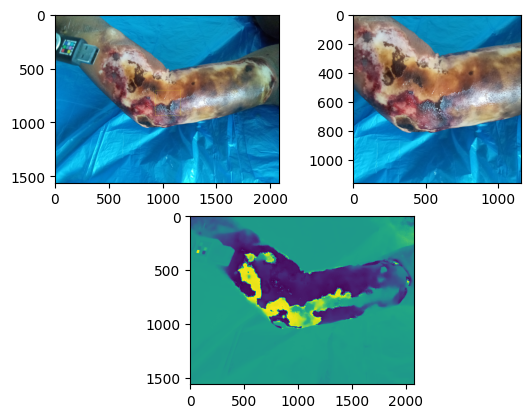

Processing image: CD00001540_20220318082334_0002_20220318082450_20220318_082455.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


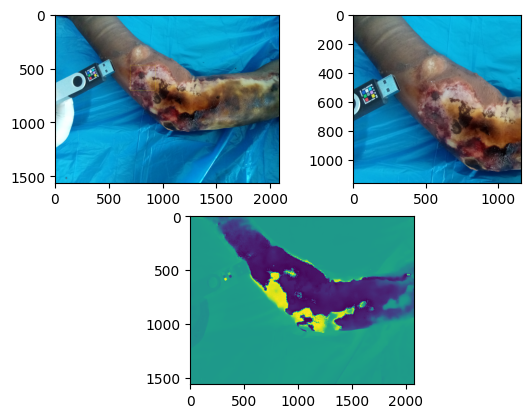

Processing image: CD00001540_20220318082334_0002_20220318082450_20220318_082552.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


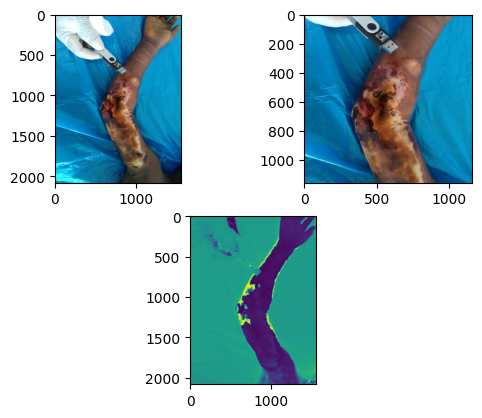

Processing image: CD00001540_20220318082334_0002_20220318082450_20220318_082610.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


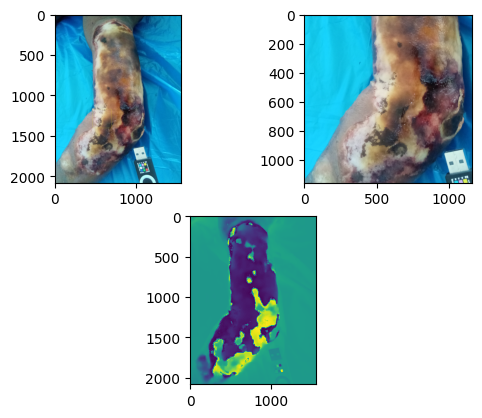

Processing image: CD00001540_20220402084436_0002_20220402084529_20220402_090131.jpg
Original Image (Left) & Superpixel with the highest hue (Right):
Skipping image CD00001540_20220402084436_0002_20220402084529_20220402_090131.jpg due to error: zero-size array to reduction operation minimum which has no identity
Processing image: CD00001546_20220919162249_0002_20220919162342_20220919_162726.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


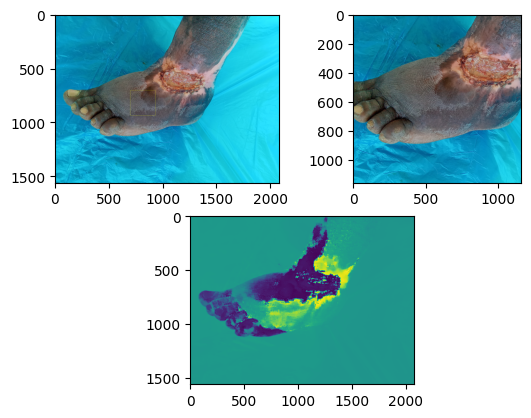

Processing image: CD00001546_20220919162249_0002_20220919162342_20220919_162823.jpg
Original Image (Left) & Superpixel with the highest hue (Right):


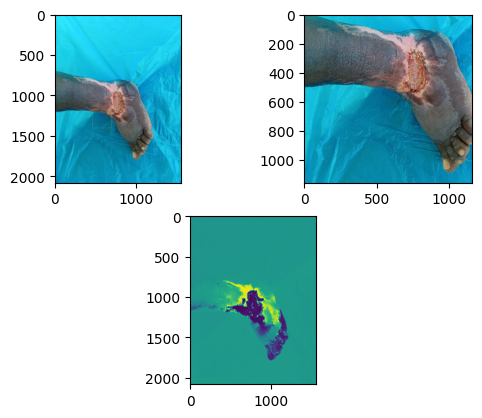

Processing image: CD00001546_20220919162249_0002_20220919162342_20220919_162842.jpg


KeyboardInterrupt: ignored

In [12]:
folder_path = "/content/drive/MyDrive/Skin/BU/"
process_folder(folder_path)